In [1]:
# Numerical modules
import numpy as np
import qutip as qt
from scipy import fftpack

# plotting setup
import matplotlib.pyplot as plt
plt.style.use('../SciencePlots-APS.mplstyle')

In [2]:
def sigmax_k(k, N):
    '''
    Calculate \sigma^{x}_{i}
    '''
    if k < 0 or k >= N:
        raise ValueError(f"Position k = {k} is out of range for N = {N}")
    ops = [qt.qeye(2) if i != k else qt.sigmax() for i in range(N)]
    return qt.tensor(ops)

def sigmay_k(k, N):
    '''
    Calculate \sigma^{y}_{i}
    '''
    if k < 0 or k >= N:
        raise ValueError(f"Position k = {k} is out of range for N = {N}")
    ops = [qt.qeye(2) if i != k else qt.sigmay() for i in range(N)]
    return qt.tensor(ops)

def sigmaz_k(k, N):
    '''
    Calculate \sigma^{z}_{i}
    '''
    if k < 0 or k >= N:
        raise ValueError(f"Position k = {k} is out of range for N = {N}")
    ops = [qt.qeye(2) if i != k else qt.sigmaz() for i in range(N)]
    return qt.tensor(ops)

def TFIM_Ham(L, J, h):
    '''
    Generate the Hamiltonian for the transverse field Ising model
    '''
    H = -J * sum([sigmax_k(i, L) * sigmax_k((i + 1) % L, L) for i in range(L)]) - h * sum([sigmaz_k(i, L) for i in range(L)])
    return H

In [3]:
# Define variables
L = 11
J0 = 1.
h = 3.

# Generate the Hamiltonian
H = TFIM_Ham(L, J0, h)

In [4]:
# Create the initial state as a superposition of two product states
# in qutip |up> = |0> and |down> = |1>
st = "".join("0" for i in range(L//2)) + "1" + "".join("0" for i in range(L//2))
st_0 = "".join("0" for i in range(L))
basis_states = [qt.basis(2, int(s)) for s in st]
basis_state0 = [qt.basis(2, int(s)) for s in st_0]

# Corrected initial state
psi1 = (qt.tensor(basis_state0) + qt.tensor(basis_states)).unit()  # Superposition with normalization

In [5]:
# Time evolution
times = np.linspace(0.0, 20, 150, endpoint=True)
result = qt.sesolve(H, psi1, times)

# Observables
n_list = [sigmay_k(i, L) for i in range(L)]
n_t = np.array([qt.expect(n, result.states) for n in n_list]).T

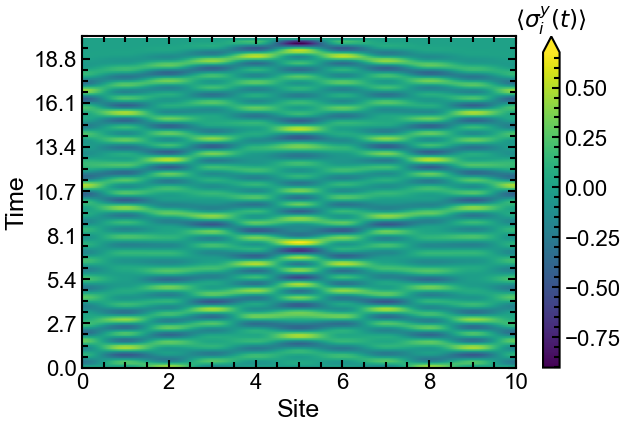

In [6]:
fig=plt.imshow(n_t[::-1],aspect = 'auto',interpolation=None)
plt.xlim(0, L-1)
plt.xlabel('Site')
plt.ylabel('Time')
plt.ylim(0, len(times))
plt.yticks(np.arange(0, len(times), 20), [f'{t:.1f}' for t in times[::20]])
cbar = plt.colorbar(fig, orientation='vertical', extend='max')
cbar.ax.set_title(r'$\langle \sigma^{y}_{i}(t)\rangle$')
plt.show()

In [7]:
steps = len(times)
dt = times[1] - times[0]
# Compute Fourier transform of observables, and lists of momenta/energies
ft = np.abs(np.fft.fft2(n_t, norm=None))
ft = np.fft.fftshift(ft)
energies = fftpack.fftshift(fftpack.fftfreq(steps) * (2.*np.pi/dt))
# Normalise FT
data = np.abs(ft)/np.max(np.abs(ft))

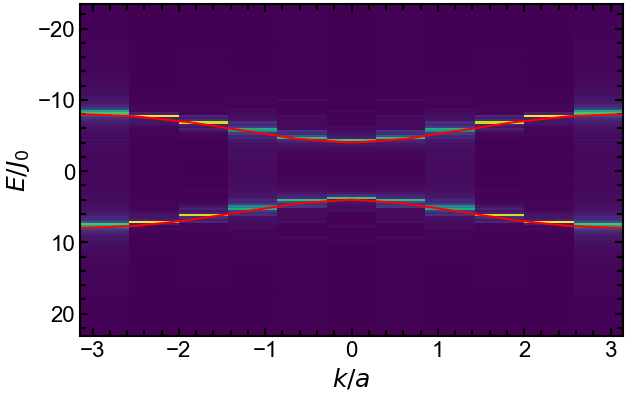

In [8]:
spectrum = np.zeros(L)
krange = np.linspace(-np.pi,np.pi,L)
for i in range(L):
    spectrum[i] = 2*np.sqrt(h**2+J0**2-2*h*J0*np.cos(krange[i]))

# Plot 2D Fourier transform
plt.imshow(data[::-1], aspect = 'auto', interpolation = 'none' , extent = (-np.pi, np.pi, max(energies)/J0, min(energies)/J0))
plt.plot(krange,spectrum,'r-')
plt.plot(krange,-1*spectrum,'r-')

plt.xlabel(r'$k/a$')
plt.ylabel(r'$E/J_{0}$')
plt.show()